## Importing PyTorch and setting up device agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
# Setup device agnostics code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

Our dataset is a subset of Food101 dataset.

Food 101 has 101 different classes of food and 1000 images per class (750 trainind, 250 testing)

Our dataset starts with 3 classes of food and 75 training, 25 testing.

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase scale when necessary.

The whole point is to sped up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/food101_mini/data/")
image_path= data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(requests.content)

  # Unzip data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as z:
    print('Unzipping data')
    z.extractall(image_path)


/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi directory already exists


## 2. Data preparation and exploration

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning it's content"""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi
There are 3 directories and 0 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test
There are 0 directories and 25 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train
There are 0 directories and 78 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train/sushi


In [ ]:
# Setup training and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all the image paths
2. Pick a random image using Python's random.choice()
3. Get the image cllass name using `pathlib.Path.parent.stem`
4. since we're working with images, let's open the image with Python's PIL(pillow)
5. We'll then show image and print metadata

Random Image Path: /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/sushi/1742201.jpg
Image class: sushi
Image height: 512
Image width: 512


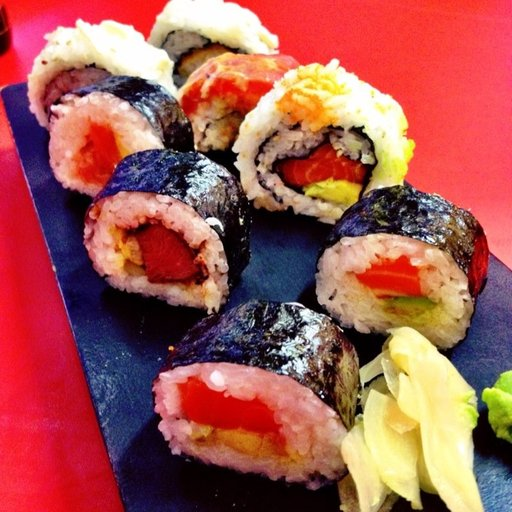

In [ ]:
import random
from PIL import Image

# Setup seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

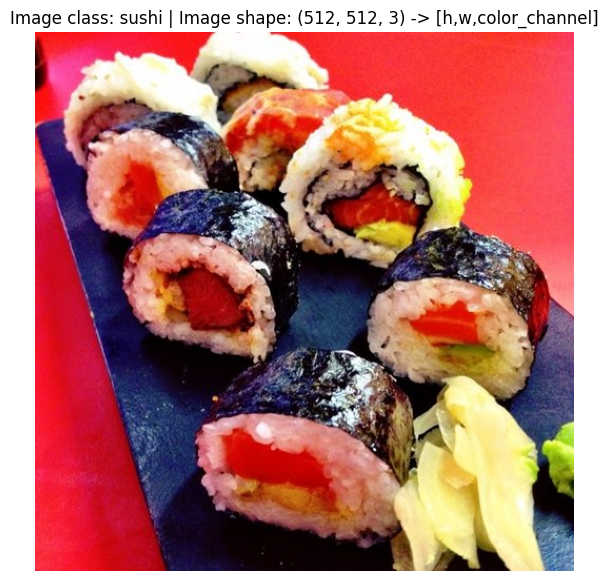

In [ ]:
# With matplotlib...
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [h,w,color_channel]");
plt.axis(False);

array([[[252,  19,  15],
        [250,  21,  16],
        [249,  26,  19],
        ...,
        [251,  56,  96],
        [249,  54,  98],
        [255,  61, 105]],

       [[251,  22,  19],
        [250,  22,  19],
        [245,  26,  20],
        ...,
        [252,  57,  97],
        [249,  54,  96],
        [255,  61, 105]],

       [[246,  22,  20],
        [243,  24,  20],
        [239,  24,  19],
        ...,
        [253,  58,  98],
        [249,  54,  96],
        [255,  61, 103]],

       ...,

       [[253,  47,  70],
        [255,  51,  74],
        [255,  49,  72],
        ...,
        [110, 151, 183],
        [108, 149, 179],
        [ 91, 132, 160]],

       [[245,  39,  62],
        [244,  38,  61],
        [248,  42,  65],
        ...,
        [103, 144, 176],
        [100, 141, 169],
        [113, 157, 182]],

       [[248,  42,  65],
        [243,  37,  60],
        [251,  45,  68],
        ...,
        [126, 167, 197],
        [ 99, 143, 170],
        [114, 158, 183]]], dtype=uint8)
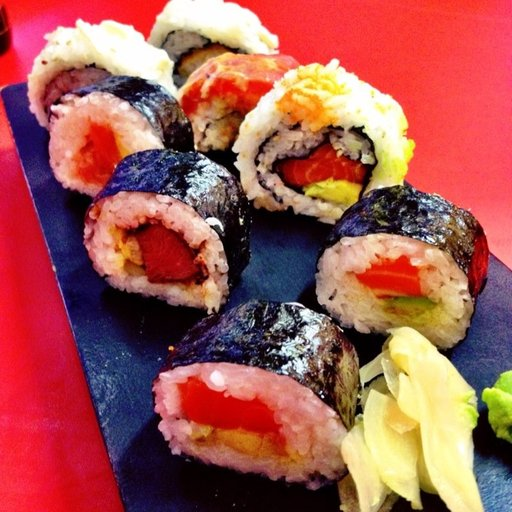

In [ ]:
img_as_array

## 3. Transforming data

Befor we can use image darta with PyTorch:
1. Turn your data into tensors(in our case, numerical representation of our image)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` (`Datasets` and `DataLoader`)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model / perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=(64,64)),
    # Flip images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.8902, 0.9804, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
         [0.6706, 0.9529, 0.9882,  ..., 0.9882, 0.9843, 0.9804],
         [0.5137, 0.9176, 0.9804,  ..., 0.9882, 0.9843, 0.9843],
         ...,
         [0.9804, 0.9804, 0.9804,  ..., 0.3294, 0.3804, 0.4157],
         [0.9804, 0.9804, 0.9804,  ..., 0.3490, 0.3686, 0.4039],
         [0.9843, 0.9804, 0.9843,  ..., 0.3216, 0.3490, 0.4157]],

        [[0.0745, 0.0863, 0.0980,  ..., 0.2275, 0.2314, 0.2275],
         [0.0431, 0.1137, 0.1294,  ..., 0.2431, 0.2471, 0.2392],
         [0.0353, 0.1294, 0.1725,  ..., 0.2745, 0.2706, 0.2745],
         ...,
         [0.1725, 0.1765, 0.1608,  ..., 0.4980, 0.5451, 0.5608],
         [0.1725, 0.1647, 0.1412,  ..., 0.5294, 0.5255, 0.5451],
         [0.1804, 0.1686, 0.1412,  ..., 0.4941, 0.5059, 0.5569]],

        [[0.0745, 0.1020, 0.1059,  ..., 0.2627, 0.3176, 0.3608],
         [0.0510, 0.1294, 0.1608,  ..., 0.3059, 0.3412, 0.3686],
         [0.0392, 0.1804, 0.2824,  ..., 0.3373, 0.3647, 0.

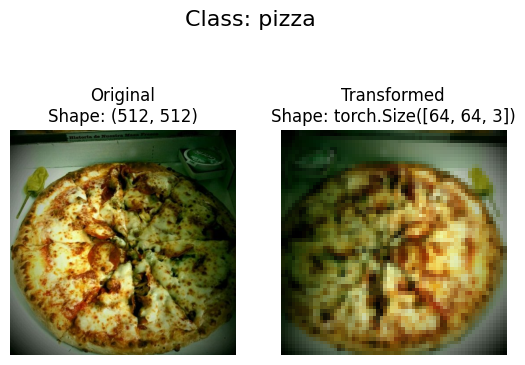

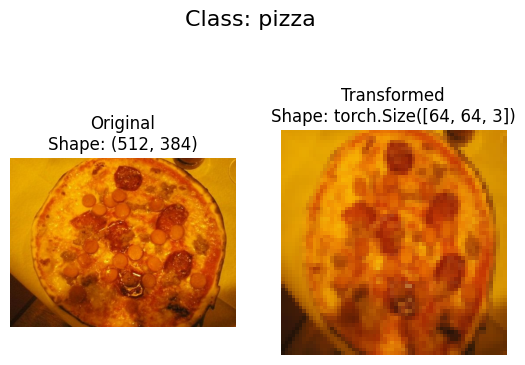

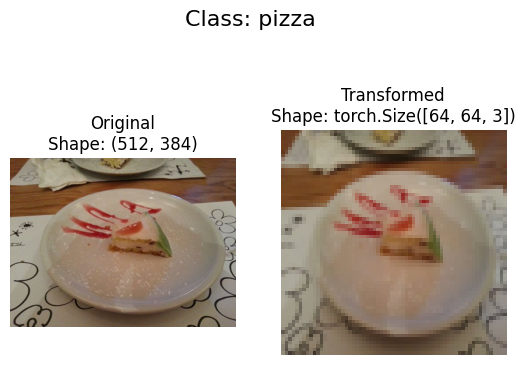

In [ ]:
def plot_transformed_images(image_path,transform,n=3,seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots original vs transformed
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nShape: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (c,h,w) -> (h,w,c)

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1:Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`


In [ ]:
# Use ImageFolder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transform for data
                                  target_transform=None) # transform for labels
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train/pizza/1008844.jpg',
 0)

In [ ]:
# Index on train_data dataset to get a single image and label
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original image shape: torch.Size([3, 64, 64]) -> [c,h,w]
Image permute: tensor([[[0.1137, 0.0745, 0.0941],
         [0.1020, 0.0706, 0.0902],
         [0.0980, 0.0745, 0.0902],
         ...,
         [0.1255, 0.0588, 0.0157],
         [0.1216, 0.0588, 0.0196],
         [0.1176, 0.0588, 0.0196]],

        [[0.1059, 0.0745, 0.0902],
         [0.0980, 0.0706, 0.0863],
         [0.0980, 0.0745, 0.0902],
         ...,
         [0.1294, 0.0627, 0.0196],
         [0.1294, 0.0627, 0.0157],
         [0.1294, 0.0627, 0.0196]],

        [[0.1020, 0.0706, 0.0902],
         [0.0980, 0.0745, 0.0902],
         [0.0941, 0.0745, 0.0902],
         ...,
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0157],
         [0.1333, 0.0706, 0.0196]],

        ...,

        [[0.1098, 0.1255, 0.1294],
         [0.1098, 0.1333, 0.1333],
         [0.1255, 0.1373, 0.1490],
         ...,
         [0.1686, 0.2510, 0.1961],
         [0.1647, 0.2392, 0.1882],
         [0.1686, 0.2392, 0.1843]],

        [[

Text(0.5, 1.0, 'pizza')

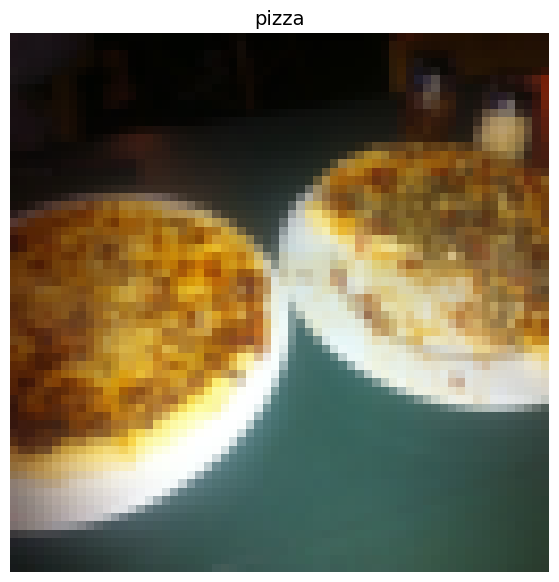

In [ ]:
# Rearrange order dimensions
img_permute = img.permute(1,2,0)

# Print original shapes
print(f"Original image shape: {img.shape} -> [c,h,w]")
print(f"Image permute: {img_permute} -> [h,w,c]")

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoaders`

A dataloader is going to help us turn our datasets into iterables and we can customise the batch_size so our model can see batch_size images at a time

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
batch_size=1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=1,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ee833aec850>,
 <torch.utils.data.dataloader.DataLoader at 0x7ee833b85450>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [b,c,h,w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [b,c,h,w]
Label shape: torch.Size([1])


## 5 Option2: Loading image data with a custom `Dataset`

1. Want to be able to load images from a file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Might lead to performance issues.

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [ ]:
# Setup path for target directory
target_dictory = train_dir
print(f"Target dir: {target_dictory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
class_names_found

Target dir: /content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numbers rather than string labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(target_dictory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory (the dir we'd like to get daa from, as well as transform if we;d like to transform our data)
3. Create several attributes:
  * paths - Paths of our images
  * transform - the transform we'd like to use
  * classes - a list of target classes
  *class_to_idx = a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2.Initialize with a targ_dir and transform parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3.Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # transforms
        self.transform = transform
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4.load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [ ]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ee833b70dd0>,
 <__main__.ImageFolderCustom at 0x7ee833b5b5d0>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equlity between original ImageFolder and custom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images
1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.
2. To prevent the display getting out of hand, we'll cap n at 10 images.
3. Set the random seed for reproducible plots
4. Get a list of random sample index from target dataset
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot with matplotlib.
7. Make sure the sample images are of shape (height, width, color) so we can plot them.

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [c, h,w] -> [h,w,c]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

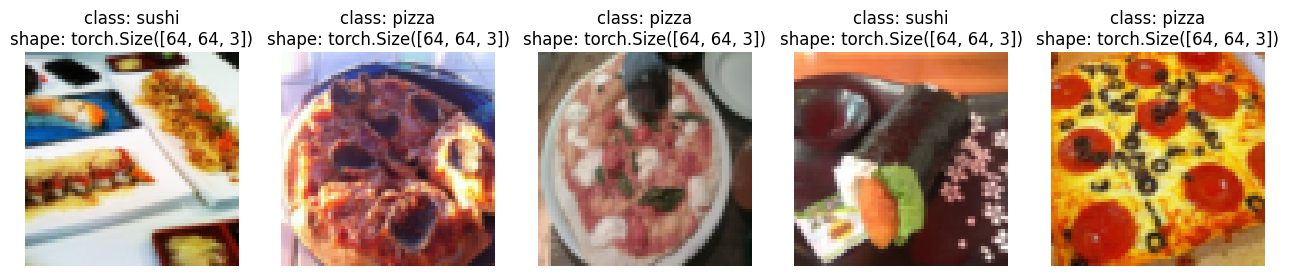

In [ ]:
# Disply random images from the ImageFolder Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

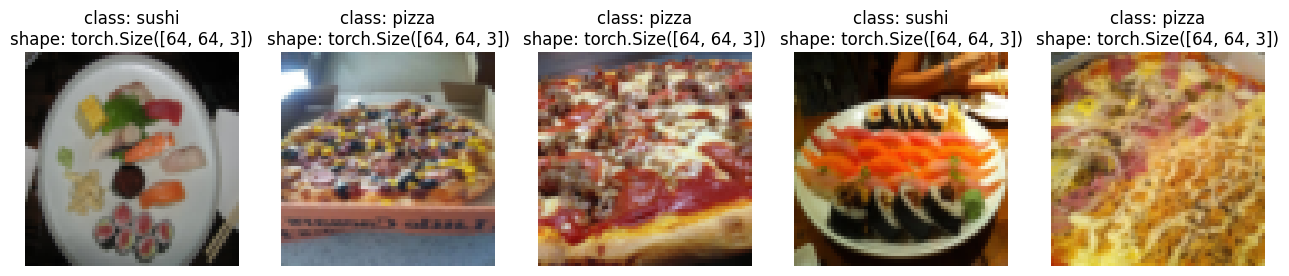

In [ ]:
# Display from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

## 5.4 Turn custom loaded images into `DataLoader`


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ee833e434d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ee833cc3250>)

In [ ]:
# Get image, label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to **SOTA** (state of the art)

In [ ]:
# Let's look at trivialaugment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),   # 0-31 (31->MAX)
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [ ]:
# Get all img paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('/content/drive/MyDrive/food101_mini/data/pizza_steak_sushi/test/pizza/344397.jpg')]

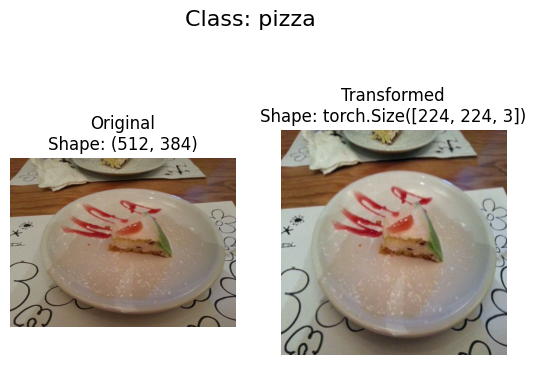

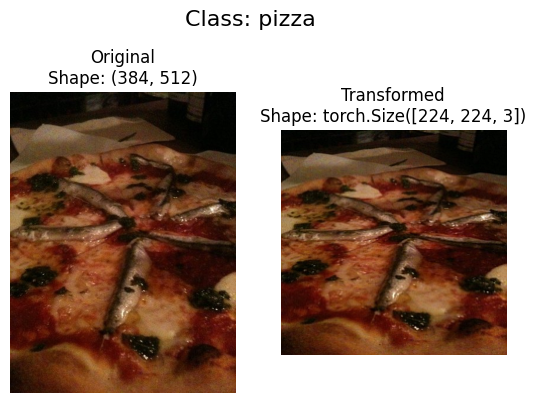

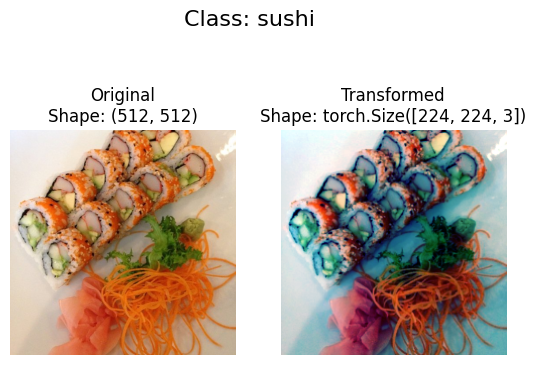

In [ ]:
# Plot random transformed images
plot_transformed_images(image_path=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG(visual geometry group) without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

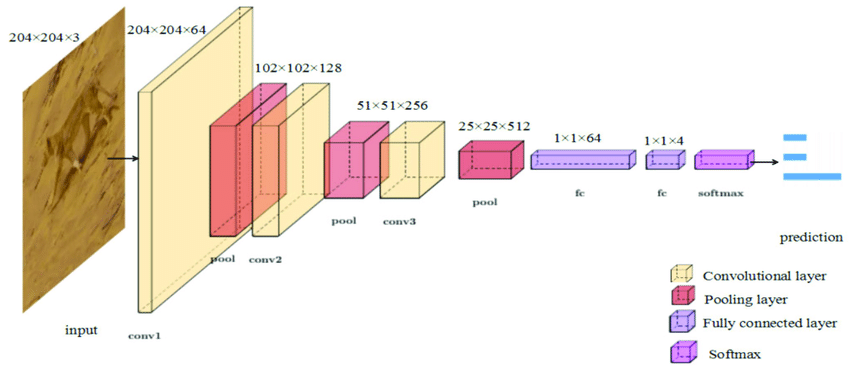

### 7.1 Creating transfroms and loading data for Model 0

In [ ]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

* Dataset: A class that represents your data and how to access individual samples.
* DataLoader: A utility that handles batching, shuffling, and parallel loading of data from the Dataset.

In [ ]:
#1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

#2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batchsize and num workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### 7.2 Create TinyVGG Model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer.
  """
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int):

    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.GELU(), # or nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # after a forard pass with a single image we can know the shape the change it with appropriate value
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))  # benifits from operator fusion(speeds up computation) : https://horace.io/brrr_intro.html


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a froward pass
model_0(image_batch.to(device))

tensor([[ 0.0188, -0.0122,  0.0047],
        [ 0.0170, -0.0093,  0.0043],
        [ 0.0179, -0.0105,  0.0041],
        [ 0.0208, -0.0140,  0.0056],
        [ 0.0173, -0.0123,  0.0057],
        [ 0.0194, -0.0105,  0.0015],
        [ 0.0199, -0.0091,  0.0076],
        [ 0.0184, -0.0125,  0.0057],
        [ 0.0203, -0.0158,  0.0074],
        [ 0.0180, -0.0123,  0.0055],
        [ 0.0191, -0.0120,  0.0048],
        [ 0.0190, -0.0158,  0.0030],
        [ 0.0184, -0.0166,  0.0037],
        [ 0.0197, -0.0123,  0.0032],
        [ 0.0187, -0.0181,  0.0037],
        [ 0.0189, -0.0153,  0.0041],
        [ 0.0181, -0.0143,  0.0053],
        [ 0.0184, -0.0156,  0.0027],
        [ 0.0182, -0.0104,  0.0035],
        [ 0.0173, -0.0095,  0.0056],
        [ 0.0193, -0.0097,  0.0050],
        [ 0.0163, -0.0152,  0.0043],
        [ 0.0194, -0.0114,  0.0049],
        [ 0.0193, -0.0158,  0.0065],
        [ 0.0179, -0.0131,  0.0043],
        [ 0.0176, -0.0098,  0.0057],
        [ 0.0174, -0.0128,  0.0035],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

# import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─GELU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step` and `test_step`

In [ ]:
from tqdm.auto import tqdm

#1. Create a train function that takes in various model parameters + optimizer + dataloader + lossfunctino

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

  #2. Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Prints out whats happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5 update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of epochs
  return results

### 7.7 Train and evaluate model 0

In [ ]:
# Set random see
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1067 | Train acc: 0.3047 | Test loss: 1.0970 | Test acc: 0.3086
Epoch: 1 | Train loss: 1.1024 | Train acc: 0.2969 | Test loss: 1.0843 | Test acc: 0.4023
Epoch: 2 | Train loss: 1.0868 | Train acc: 0.4570 | Test loss: 1.0791 | Test acc: 0.5391
Epoch: 3 | Train loss: 1.0985 | Train acc: 0.3906 | Test loss: 1.0427 | Test acc: 0.5938
Epoch: 4 | Train loss: 1.0580 | Train acc: 0.4531 | Test loss: 1.0281 | Test acc: 0.6484
Total training time: 15.237 seconds


In [ ]:
model_0_results

{'train_loss': [1.1067409813404083,
  1.102392628788948,
  1.0867860019207,
  1.098486378788948,
  1.0579915940761566],
 'train_acc': [0.3046875, 0.296875, 0.45703125, 0.390625, 0.453125],
 'test_loss': [1.0969916731119156,
  1.0843445956707,
  1.0790850818157196,
  1.042748212814331,
  1.0280510634183884],
 'test_acc': [0.30859375, 0.40234375, 0.5390625, 0.59375, 0.6484375]}

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time.

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str,List[float]]):
  """
  Plots training curves of a results dictionary.
  """
  # Get the loss values of the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the acc
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure how many epochs are there
  epochs = range(len(results["train_loss"]))

  # Setup plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1) # r,c,index
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

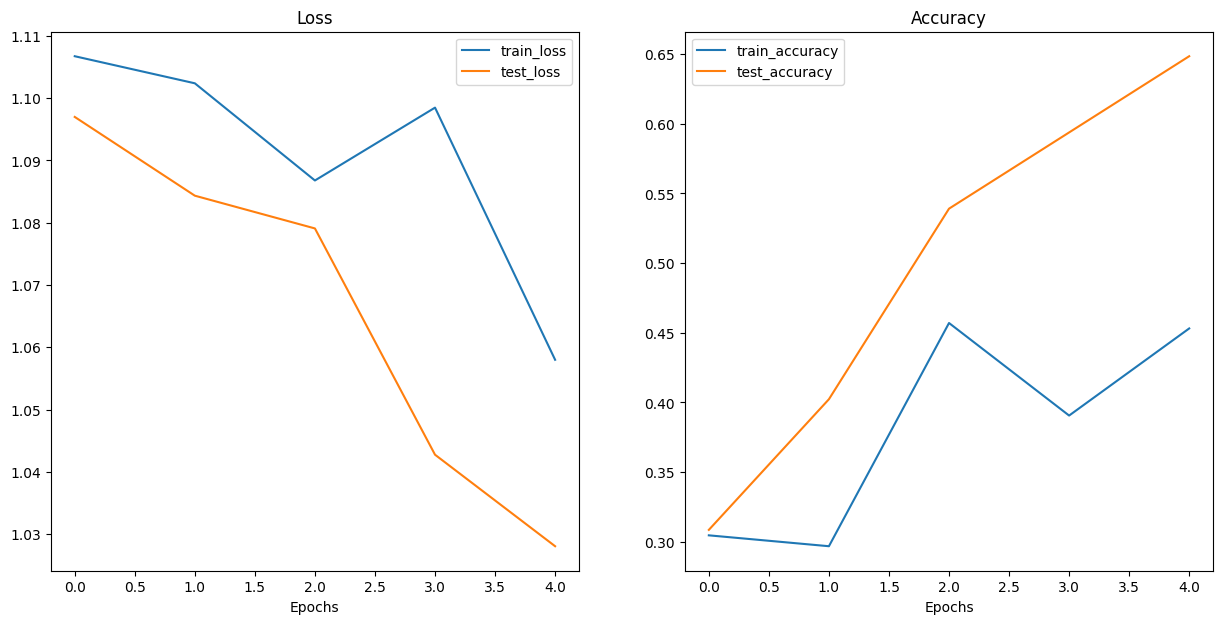

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

A loss curve is one of the most

## 9. Model 1: TinyVGG with data augmentation

Now let's try another modelling experinmetn this time using the same model as before with data augmentation

### 9.1 Create transfrom with data augmentation


In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Datasets` and `DataLoader` with augmentation

In [ ]:
# Turn image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn dataset into dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data

In [ ]:
# Create model_1 and send it to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Now we've created a model and dataloader, let's create a loss function and an optimizer and call upon our `train()` function to train our model.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1048 | Train acc: 0.2500 | Test loss: 1.0982 | Test acc: 0.3047
Epoch: 1 | Train loss: 1.0804 | Train acc: 0.4258 | Test loss: 1.1101 | Test acc: 0.3047
Epoch: 2 | Train loss: 1.0687 | Train acc: 0.4258 | Test loss: 1.1253 | Test acc: 0.3047
Epoch: 3 | Train loss: 1.1229 | Train acc: 0.3047 | Test loss: 1.1132 | Test acc: 0.3047
Epoch: 4 | Train loss: 1.0815 | Train acc: 0.4336 | Test loss: 1.1067 | Test acc: 0.4258
Total training time: 13.880 seconds


In [ ]:
model_1_results

{'train_loss': [1.1047943532466888,
  1.0803973227739334,
  1.068675510585308,
  1.122947633266449,
  1.0815346539020538],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.43359375],
 'test_loss': [1.0982256978750229,
  1.1100770831108093,
  1.1253400444984436,
  1.1131608411669731,
  1.1067304015159607],
 'test_acc': [0.3046875, 0.3046875, 0.3046875, 0.3046875, 0.42578125]}

### 9.4 Plot loss curves of model 1

A loss curve helps you evaluate your model performance overtime

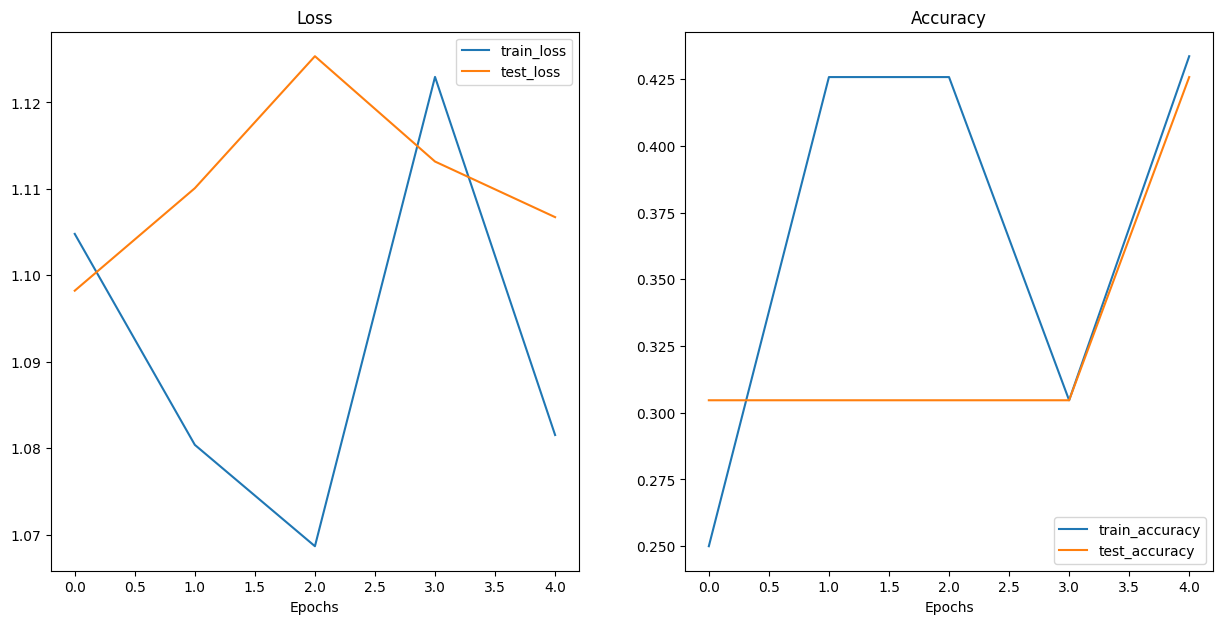

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other

There are a few different ways to do this:
1. Hard coding
2. PyTorch + tensorboard
3. Weights and biases
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106741   0.304688   1.096992  0.308594
1    1.102393   0.296875   1.084345  0.402344
2    1.086786   0.457031   1.079085  0.539062
3    1.098486   0.390625   1.042748  0.593750
4    1.057992   0.453125   1.028051  0.648438

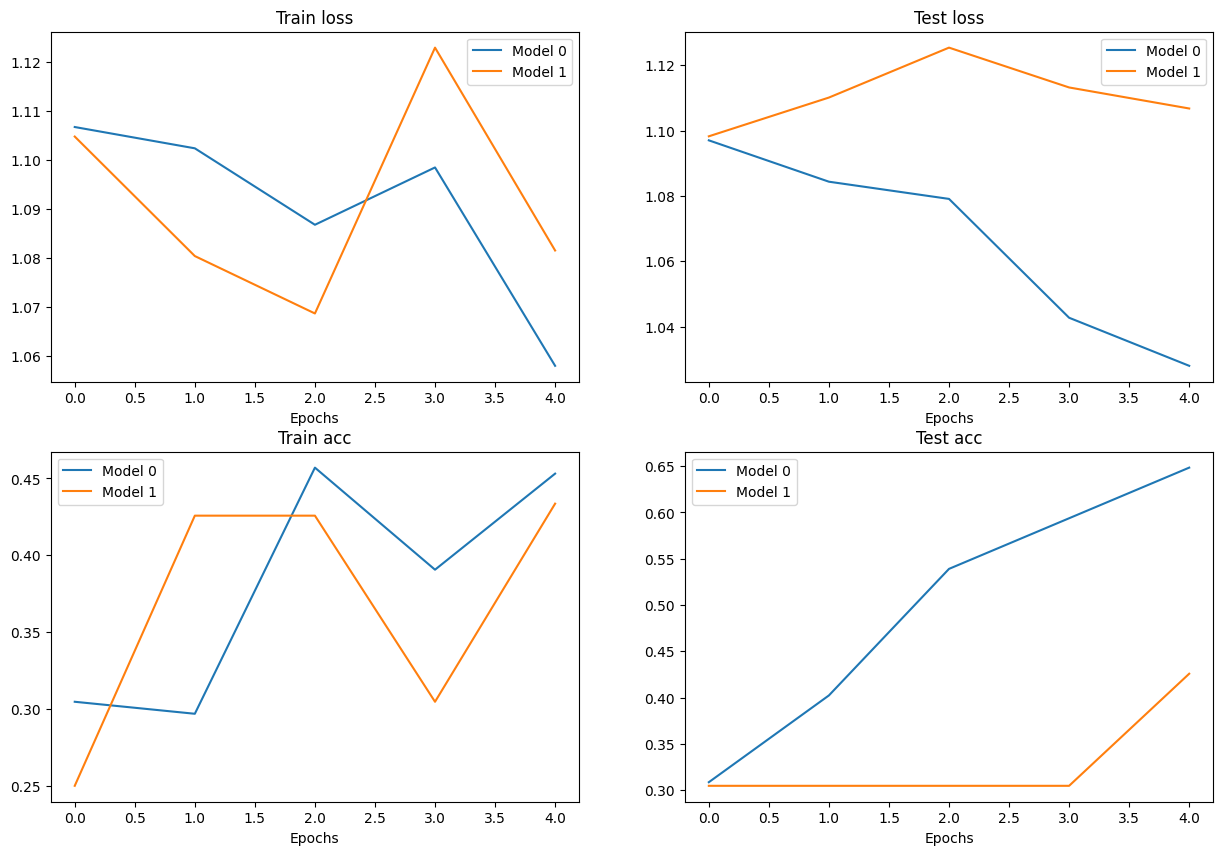

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"], label="Model 0")
plt.plot(epochs,model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend();

# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"], label="Model 0")
plt.plot(epochs,model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend();

# plot test acc
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"], label="Model 0")
plt.plot(epochs,model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend();

# plot test acc
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"], label="Model 0")
plt.plot(epochs,model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making predictionon a custom image
Although we've trained a model on custom data... how do you make prediction on a sample/image that is not in either training or testing

In [ ]:
# Dowload a custom image

import requests

# Setup custom images path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download image, if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    # When downloading from GitHub we need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exits")

/content/drive/MyDrive/food101_mini/data/04-pizza-dad.jpeg already exits


### 11.1 Loading in custom image with PyTorch

We have to make sure custom image is in the same format as the data our model was trained on:
* In tensor form with datatype(torch.float.32)
* Of shape 64x64x3
* On the right device

In [ ]:
import torchvision

# Read an custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

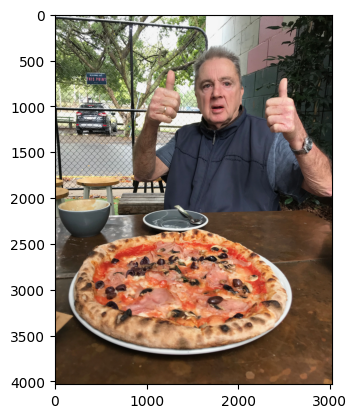

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0));

### 11.2 Making a prediction on a custom image with a traind PyTorch model

In [ ]:
# Load custom image and convet to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255   # For image values to be between 0,1 we divide by 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
from torchvision import transforms
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transfomed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transfomed shape: torch.Size([3, 64, 64])


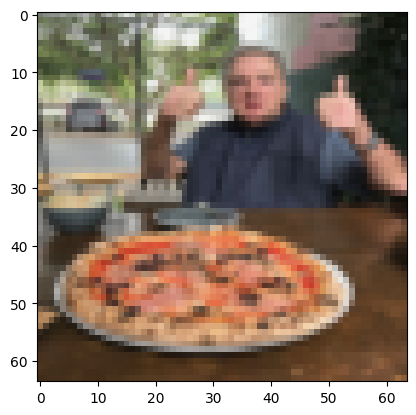

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0));

In [ ]:
custom_image_transformed.shape,custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# This should work (added a batch size...)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0714,  0.0344, -0.1668]], device='cuda:0')

Note, to mae a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as model (torch.float32)
* Make sure the image was the same shape as the data the model as trained on (3,64,64) with a batch size... (1,3,64,64)
* Make sure the image was on the same device of of models

In [ ]:
# Convert logits -> pred probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3634, 0.3502, 0.2864]], device='cuda:0')

In [ ]:
# Convert pred probs -> pred labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: Building a function
Ideal outcome:

 A function where we pass an image path to and have our model predict on thati mage with plot the image+prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """
    Makes a prediction on a target image and plots the image with its prediction.
    """

    # 1.Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2.Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3.Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4.Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

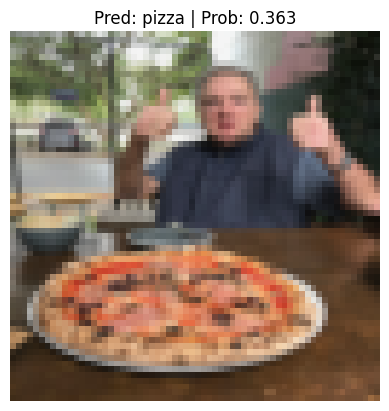

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)